<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: [*Wenbo*]
### ***username***: [*Yu*]
### ***CID***: [*02452289*]


You can save this notebook in Colab by clicking `File` from the top menu, and then selecting `Download --> Download .ipynb`

Make sure that when you save your notebook you have all the cells executed and you can see the outputs (livelossplot graphs, etc)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# !cp -r /content/drive/MyDrive/dl_cw2/raw_data.tar.gz '/content/raw_data.tar.gz'
# !tar -xzvf raw_data.tar.gz

In [2]:
# !cp -r /content/drive/MyDrive/dl_cw2/test_hands.tar.gz '/content/test_hands.tar.gz'
# !tar -xzvf test_hands.tar.gz

In [3]:
# !pip install livelossplot
# !pip install torchinfo

## 1. Model selection

In this coursework I will choose ResNet (Residual Network) to differentiate between GAN-generated, VAE-generated and real hand images for several reasons:
1. In image classification tasks, deeper networks are likely to have the ability to learn more complex patterns, which is beneficial in distinguishing between images with subtle differences, and the introduction of residual connectivity in ResNet can achieve better results when training deeper networks.
2. ResNet's residual connectivity helps mitigate the problem of gradient vanishing in deep networks. This allows the network to learn efficiently even when the number of layers becomes very large, making it suitable for complex classification tasks.
3. The architecture of ResNet, especially its deeper network, is robust to overfitting, which is reasonable to introduce considering the limited number of samples in the current dataset, where model training is more prone to overfitting.

## 2. Data preparation
This section defines functions for data preprocessing and dataset production.

In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from torchvision import datasets, transforms
plt.style.use('default')

def visualize_images(image_path, cols=10, rows=10, seed=42, transform=None):
    random.seed(seed) # <- try changing this and see what happens
    image_path = Path(image_path)
    image_path_list = list(image_path.glob("*/*.jpeg"))
    figure = plt.figure(figsize=(8, 8))

    for i in range(cols * rows):
        random_image_path = random.choice(image_path_list)
        img = Image.open(random_image_path)

        figure.add_subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(img, cmap="gray")

    return image_path_list

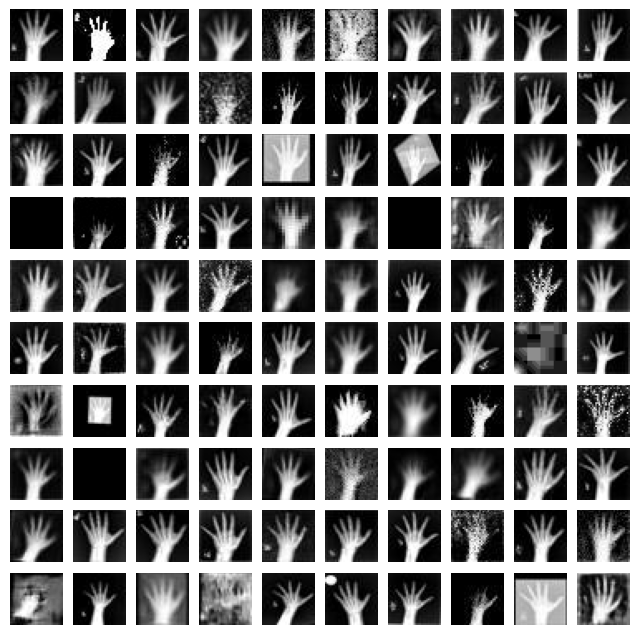

In [3]:
image_path_list = visualize_images('raw_data')

### 2.1 Train-Test split functions

In [5]:
import os
import shutil
import random
from tqdm.auto import tqdm
import shutil
from pathlib import Path
import os
# Function to split data into train, test, and validate sets
def split_data(source_folder, dest_folder, seed=42, train_ratio=0.8, test_ratio=0.2, val_ratio=0):
    # Set seed for reproducibility
    random.seed(seed)
    # Check if the total ratio is approximately 1
    if abs(train_ratio + test_ratio + val_ratio - 1) > 0.01:
        raise ValueError("The sum of the ratios must be approximately 1")
    # Delete the destination folder if it exists
    if os.path.exists(dest_folder):
        shutil.rmtree(dest_folder)
    # Create destination folders
    os.makedirs(os.path.join(dest_folder, "train"), exist_ok=True)
    os.makedirs(os.path.join(dest_folder, "test"), exist_ok=True)
    os.makedirs(os.path.join(dest_folder, "validate"), exist_ok=True)
    # Process each subfolder in the source folder
    for subfolder in os.listdir(source_folder):
        full_subfolder_path = os.path.join(source_folder, subfolder)

        if os.path.isdir(full_subfolder_path):
            # List all files in the subfolder
            files = [f for f in os.listdir(full_subfolder_path) if os.path.isfile(os.path.join(full_subfolder_path, f))]
            random.shuffle(files)  # Shuffle the files
            # Calculate split indices
            total_files = len(files)
            train_end = int(total_files * train_ratio)
            test_end = train_end + int(total_files * test_ratio)
            # Function to copy files
            def copy_files(files_to_copy, target_subfolder):
                dest_subfolder_path = os.path.join(dest_folder, target_subfolder, subfolder)
                os.makedirs(dest_subfolder_path, exist_ok=True)
                for file in files_to_copy:
                    shutil.copy(os.path.join(full_subfolder_path, file), dest_subfolder_path)
            # Split files into train, test, and validate sets and copy them
            copy_files(files[:train_end], "train")
            if val_ratio == 0:
                copy_files(files[train_end:], "test")
            else:
                copy_files(files[train_end:test_end], "test")
                copy_files(files[test_end:], "validate")

### 2.2 Define data fransformer

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Write transform for image
def data_transform(shape=32, flip_prob=0.5):
    # Write transform for image
    data_transform = transforms.Compose([
        # Resize the images to 32x32
        transforms.Resize(size=(shape, shape)),
        transforms.RandomHorizontalFlip(p=flip_prob), # p = probability of flip, 0.5 = 50% chance
        transforms.RandomRotation(degrees=10), # rotate up to 10 degrees
        transforms.Grayscale(),
        transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
        # normalize
        # transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    return data_transform

In [7]:
def visualize_transformed_images(image_path, cols=10, rows=10, seed=42, transform=data_transform()):
    random.seed(seed) # <- try changing this and see what happens
    image_path = Path(image_path)
    image_path_list = list(image_path.glob("*/*.jpeg"))
    figure = plt.figure(figsize=(8, 8))

    for i in range(cols * rows):
        random_image_path = random.choice(image_path_list)
        img = Image.open(random_image_path)
        if transform:
            img = transform(img)

        figure.add_subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")

    return image_path_list

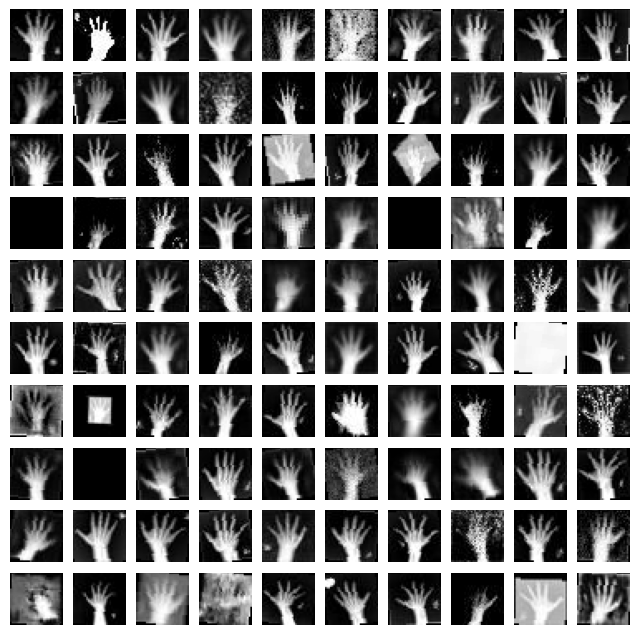

In [8]:
image_path_list = visualize_transformed_images('raw_data')

### 2.3 Defind data loader

In [9]:
def get_data_loader(data_folder, batch_size=16, transform=data_transform()):
    train_dataset = datasets.ImageFolder(root=os.path.join(data_folder, "train"), transform=transform)
    test_dataset = datasets.ImageFolder(root=os.path.join(data_folder, "test"), transform=transform)
    # Customize labels
    custom_labels = {"real": 0, "vae": 1, "gan": 2}  # Define your custom labels here
    train_dataset.class_to_idx = custom_labels
    test_dataset.class_to_idx = custom_labels
    # Optionally, update the samples tuple to have the correct label
    train_dataset.samples = [(s[0], custom_labels[train_dataset.classes[s[1]]]) for s in train_dataset.samples]
    test_dataset.samples = [(s[0], custom_labels[test_dataset.classes[s[1]]]) for s in test_dataset.samples]
    # Get the data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

## 3. Network design and implementation


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

# Defining the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
# Function to create ResNet18
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Function to create ResNet50
def ResNet50():
    # ResNet50 uses 'Bottleneck' blocks and has a different number of layers in each block
    return ResNet(Bottleneck, [3, 4, 6, 3])  # Configuration for ResNet50

## 4. Training and evaluation loops

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from tqdm.auto import tqdm

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

def score_matrix(model, data_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  #
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()

    test_loss /= len(data_loader)
    test_accuracy = 100 * correct / total

    return test_loss, test_accuracy

def save_model(model: torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               checkpoint_dir: str,
               model_name: str,
               epoch=None,
               log=None,
               info=False):
  # Create target directory
  checkpoint_dir_path = Path(checkpoint_dir)
  checkpoint_dir_path.mkdir(parents=True, exist_ok=True)

  # Create model path
  if epoch is not None:
    model_name = f"{model_name}_{epoch}.pth"
  else:
    model_name = f"{model_name}.pth"

  model_save_path = checkpoint_dir_path / model_name
  checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
  }
  if log is not None:
      checkpoint['log'] = log
  torch.save(obj=checkpoint, f=model_save_path)
  # Save the model state_dict()
  if info:
    print(f"[INFO] Saving model to: {model_save_path}")

def load_model(model: torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               checkpoint_dir: str,
               checkpoint: str,
               info=False):
    checkpoint = f"{checkpoint}.pth"
    load_path = Path(checkpoint_dir) / checkpoint
    print(load_path)
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    log = None
    if 'log' in checkpoint:
        log = checkpoint['log']
    if info:
        print(f"[INFO] Loading model from: {load_path} at epoch: {epoch}")
    return model, optimizer, epoch, log

def train(model, train_loader, criterion, optimizer, n_epochs,
                       device='cpu',
                       logs=None,
                       checkpoint_dir='./models/',
                       model_name='resnet18',
                       checkpoint=None,
                       save_inv=5):
    checkpoint_dir = Path(checkpoint_dir) / model_name
    start_epoch = 0
    model.to(device)
    model.train()
    if logs is None:
        logs = {'train_losses': [], 'train_accuracies': []}
    groups = {'Accuracy': ['Train_Accuracy'],
              'Loss': ['Train_Loss']}
    liveloss = PlotLosses(groups=groups)
    liveloss.update({})
    # load checkpoint
    if checkpoint is not None:
        model, optimizer, start_epoch, _ = load_model(model, optimizer, checkpoint_dir, checkpoint, info=True)
        # liveloss loads the previous epoch
        for _ in range(start_epoch + 1):
          liveloss.update({})

    for epoch in tqdm(range(start_epoch, start_epoch + n_epochs), initial=start_epoch, total=start_epoch + n_epochs):
        current_epoch = epoch + 1
        log = {}
        total = 0
        correct = 0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # if images.size(0) != labels.size(0):
            #   raise ValueError(f"Batch size mismatch: images size {images.size(0)} != labels size {labels.size(0)}")
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  #

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total

        log['Train_Loss'] = train_loss
        log['Train_Accuracy'] = train_accuracy


        liveloss.update(log)
        liveloss.draw()

        logs['train_losses'].append(train_loss)
        logs['train_accuracies'].append(train_accuracy)

        # save model every save_inv epochs
        if current_epoch % save_inv == 0:
            save_model(model, optimizer, checkpoint_dir, model_name, epoch=current_epoch, log=log)
        model.train()

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, n_epochs,
                       device='cpu',
                       logs=None,
                       checkpoint_dir='./models/',
                       model_name='resnet18',
                       checkpoint=None,
                       save_inv=5):
    checkpoint_dir = Path(checkpoint_dir) / model_name
    start_epoch = 0
    model.to(device)
    model.train()
    if logs is None:
        logs = {'train_losses': [], 'test_losses': [], 'train_accuracies': [], 'test_accuracies': []}
    groups = {'Accuracy': ['Train_Accuracy', 'Test_Accuracy'],
              'Loss': ['Train_Loss', 'Test_Loss']}
    liveloss = PlotLosses(groups=groups)
    liveloss.update({})
    # load checkpoint
    if checkpoint is not None:
        model, optimizer, start_epoch, _ = load_model(model, optimizer, checkpoint_dir, checkpoint, info=True)
        # liveloss loads the previous epoch
        for _ in range(start_epoch + 1):
          liveloss.update({})

    for epoch in tqdm(range(start_epoch, start_epoch + n_epochs), initial=start_epoch, total=start_epoch + n_epochs):
        current_epoch = epoch + 1
        log = {}
        total = 0
        correct = 0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # if images.size(0) != labels.size(0):
            #   raise ValueError(f"Batch size mismatch: images size {images.size(0)} != labels size {labels.size(0)}")
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  #

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        test_loss, test_accuracy = score_matrix(model, test_loader, criterion, device)

        log['Train_Loss'] = train_loss
        log['Test_Loss'] = test_loss
        log['Train_Accuracy'] = train_accuracy
        log['Test_Accuracy'] = test_accuracy

        liveloss.update(log)
        liveloss.draw()

        logs['train_losses'].append(train_loss)
        logs['test_losses'].append(test_loss)
        logs['train_accuracies'].append(train_accuracy)
        logs['test_accuracies'].append(test_accuracy)

        # save model every save_inv epochs
        if current_epoch % save_inv == 0:
            save_model(model, optimizer, checkpoint_dir, model_name, epoch=current_epoch, log=log)
        model.train()

## 5. Network training and Hyperparameters tunning

This section will select the optimal model for the implementation of the complete training workflow.

<span style="color: red;">Please note</span> that due to time constraints, it is normal that the execution results of the code blocks shown here do not coincide with the training epoch of the final model, so the model used in the final result, i.e., the sample image generation section, is the model imported from one of the training **checkpoints**, as described in the subsequent notes.

The checkpoints in this coursework are all from the models defined in the **Network design and implementation section**.



### 5.1 Dataset and Dataloader

In [12]:
split_data('raw_data', 'data')

In [13]:
train_dataloader, test_dataloader =  get_data_loader("data")

### 5.2 Define best hyperparameters and model (ResNet50)

The best data transform function for this model is:
```python
def data_transform(shape=32, flip_prob=0.5):
    data_transform = transforms.Compose([
        transforms.Resize(size=(shape, shape)),  # Resize the images to 32x32
        transforms.RandomHorizontalFlip(p=flip_prob), # p = probability of flip, 0.5 = 50% chance
        transforms.RandomRotation(degrees=10), # rotate up to 10 degrees
        transforms.Grayscale(),
        transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ])
    return data_transform
```

Other hyperparameters, variables, functions:
- model: ResNet50
- learning rate: 0.001
- batch size: 16
- optimizer: `Adam()`
- criterion: `CrossEntropyLoss()`

In [14]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Define the model
model = ResNet50()
# Hyperparameters
LR = 0.001
# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

Cuda installed! Running on device!


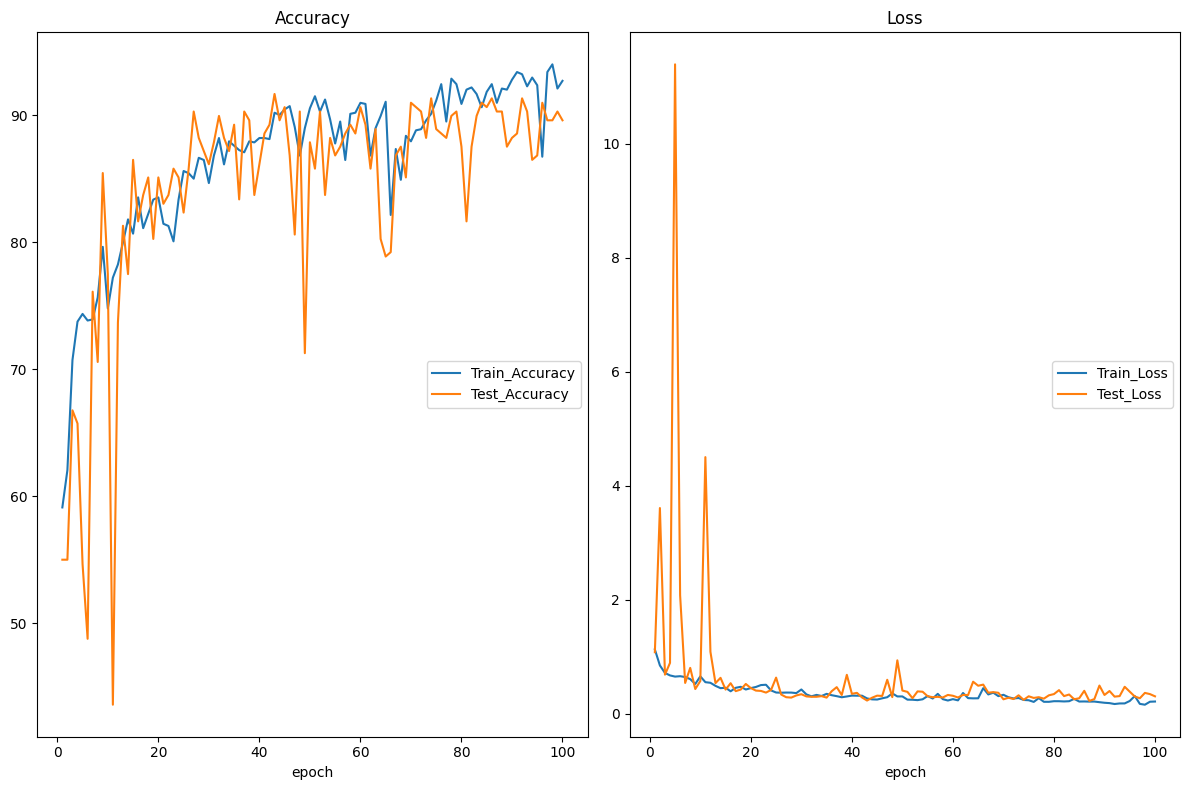

Accuracy
	Train_Accuracy   	 (min:   59.134, max:   94.026, cur:   92.727)
	Test_Accuracy    	 (min:   43.599, max:   91.696, cur:   89.619)
Loss
	Train_Loss       	 (min:    0.162, max:    1.131, cur:    0.217)
	Test_Loss        	 (min:    0.228, max:   11.390, cur:    0.309)


100%|██████████| 100/100 [06:49<00:00,  4.10s/it]


In [19]:
model = model.to(device)
train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, n_epochs=100,
                   device=device,
                   model_name='ResNet50_best',
                   save_inv=5)

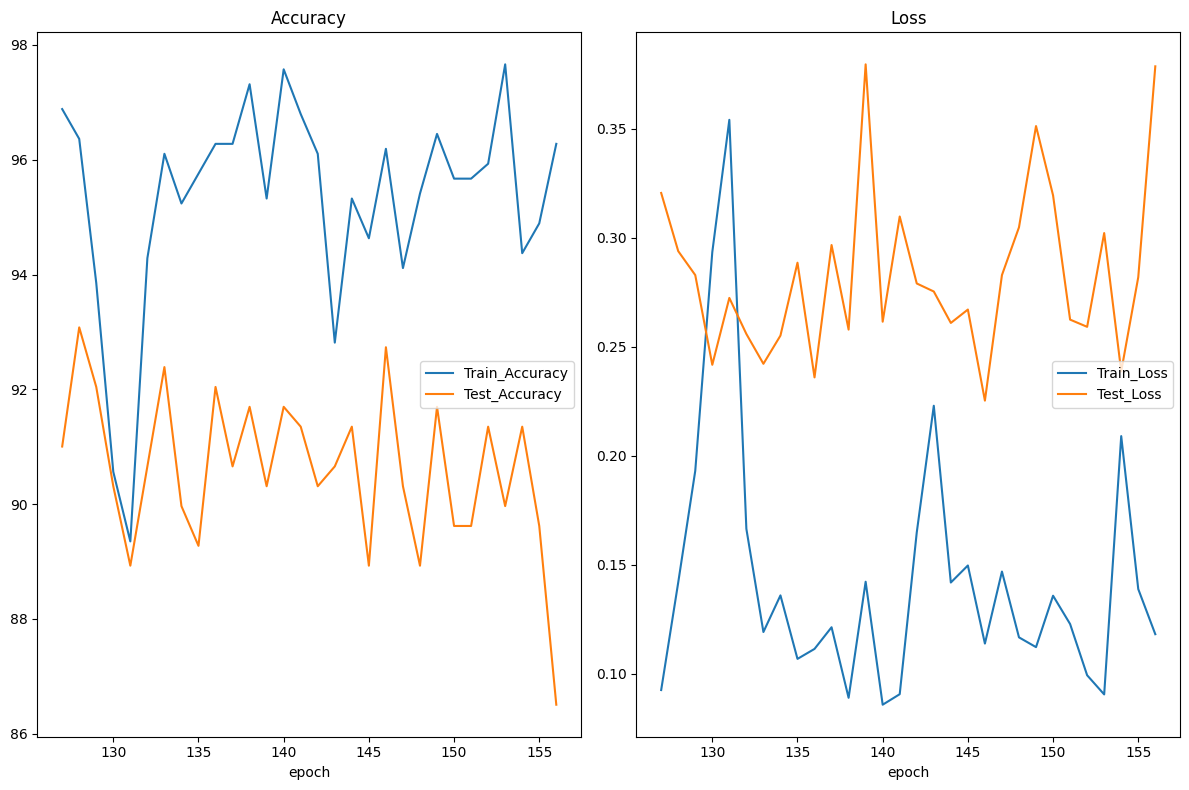

Accuracy
	Train_Accuracy   	 (min:   89.351, max:   97.662, cur:   96.277)
	Test_Accuracy    	 (min:   86.505, max:   93.080, cur:   86.505)
Loss
	Train_Loss       	 (min:    0.086, max:    0.354, cur:    0.118)
	Test_Loss        	 (min:    0.225, max:    0.380, cur:    0.379)


In [ ]:
# retrain from 100 epoch
train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, n_epochs=50,
                   device=device,
                   model_name='ResNet50_best',
                   checkpoint='ResNet50_best_100',
                   save_inv=5)

## 6. Load best model and Save predictions of test_hands

<span style="color: red;">Please note!!!</span> The final predictions with the best model (one of the checkpoints in the training process) have been saved in the `root` directory in file `acse-wy1223_classified_hands.csv`.

<span style="color: red;">Please download the best model https://drive.google.com/file/d/1fbg0LMa9t1bwD5Zna0dwvIZnZMv4zDMR/view?usp=drive_link to dir `./model_best` before running the following code block</span>.

In [20]:
# predict
import os
import pandas as pd
from PIL import Image

# Function to predict the class for each image in the folder
def make_predictions(model, folder_path, device='cpu', transform=data_transform()):
    model.to(device)
    model.eval()
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')]
    predictions = []

    for image_file in tqdm(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        # trainform =trainform
        image = transform(image)
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predictions.append((image_file, predicted.item()))

    return predictions

def save_predictions(predictions, results_dir, file_name):
    results_dir_path = Path(results_dir)
    results_dir_path.mkdir(parents=True, exist_ok=True)
    df = pd.DataFrame(predictions, columns=['Image', 'Class']).sort_values(by=['Image'])
    df.to_csv(results_dir_path / file_name, index=False, header=False)
    return df

### 6.1 Load best model

In [31]:
model_best = ResNet50()
optimizer_best = optim.Adam(model_best.parameters(), lr=0.001)
model_best, optimizer_best, _, log_best = load_model(model_best,
           optimizer_best,
           checkpoint_dir='./model_best/',
           checkpoint='ResNet50_159',
           info=True)
log_best

model_best/ResNet50_159.pth
[INFO] Loading model from: model_best/ResNet50_159.pth at epoch: 159


{'Train_Loss': 0.10321644112619377,
 'Test_Loss': 0.17091908324509858,
 'Train_Accuracy': 96.2071480671043,
 'Test_Accuracy': 97.26027397260275}

### 6.2 Save predictions

<span style="color: red;">Please note!!!</span> The results of this execution will be saved in the `./results` folder.


In [32]:
# make predictions
file_name = 'best_classified_hands.csv'
folder_path = './test_hands'  # Update with the actual folder path
predictions = make_predictions(model_best, folder_path)

  0%|          | 0/8433 [00:00<?, ?it/s]

100%|██████████| 8433/8433 [04:22<00:00, 32.12it/s]


In [33]:
# save predictions
df_pred = save_predictions(predictions, './results', file_name)